In [0]:
!pip install -q numpy scikit-learn keras matplotlib
!apt-get install unrar

# Assignment 2

Suraj Iyer (0866094)  
Sander Boelders (0916836)

***

## Question 1: Neural Codes & Nearest Neighbor retrieval (7.5pt)
The Caltech101 dataset consists of images of 101 different objects. In this question you will develop an image retrieval system using image representations (neural codes) learned with a deep convolutional neural network and a given distance metric.

In the tasks below you will need to implement the following steps:

* Retrieval for $n$ selected (distinct) query images from the dataset
    * For each query image, obtain the 5 most similar images (excluding the query image itself!)
* Evaluation of the quality of the retrieval 
    * The Caltech101 images are annotated with their object class. Use these annotations to evaluate the accuracy of the retrieval task.
    * For each query image, count the number of images whose class corresponds to the one from the query. The score of the retrieval for that image then ranges between:
        * **5** *all* retrieved images' classes agree with the query image class
        * **0** *none* of the images' classes agree with the query image class
    * Compute the average of all $n$ queries

***

### Task 1.1:  Neural codes image retrieval
**a)** Implement the retrieval task and evaluate the results for $n=200$ images. Use the provided VGG16 network pre-trained on ImageNet to compute "neural codes" and L2-distance. Specifically use the codes produces by the following layers of the model: 
1. the "fc1"-layer
2. the "fc2"-layer

Provide the retrieval evaluation scores for both tasks.

In [0]:
# you'll need these imports:
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np
import pickle

In [34]:
# Download the data zip file.
file_id = '1vHT--196RY_aoH0MReSDmFZUh2OFrS8D'
download_from_gdrive('data.zip', file_id)

Download 100%.


In [0]:
# !unrar x data.rar -f
!unzip data.zip
# rm -r data

In [44]:
!ls data

caltech101		   caltech101_VGG16_fc1.p     caltech101_VGG16_fc2.p
caltech101_VGG16_fc1_bg.p  caltech101_VGG16_fc2_bg.p


In [46]:
# NOTE: you will first need to apply some changes to "Practical-3.3.0_preprocess-caltech101.ipynb" and run it
#       to obtain a pickle file with "fc1"-features. You don't need to show these changes here.

# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

# iterate over two data representations (make sure these two files exist in the "data" subfolder first)
for j, datapath in enumerate(["caltech101_VGG16_fc1.p", "caltech101_VGG16_fc2.p"]):
  # load the dataset
  with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, _, classes = pickle.load(f)

  # fit nearest neighbors
  neigh = NearestNeighbors(n_neighbors=6, p=2, metric='l2')
  neigh.fit(X_fc)

  X = X_fc[indices]
  dist, ind = neigh.kneighbors(X)  # get 5 most similar images to query images
  dist, ind = dist[:, 1:], ind[:, 1:]  # exclude the query image itself

  scores = [sum(classes[y[idx]] == classes[y[i]] for idx in ind[k]) for k, i in enumerate(indices)]
  avg_score = np.mean(scores)
  print('{} score: {}'.format(datapath, avg_score))       

caltech101_VGG16_fc1.p score: 3.755
caltech101_VGG16_fc2.p score: 3.945


***

**b)** Which representation ("neural code") provided better features for the given retrieval task? 
Justify your answer and discuss possible reasons for the observed results. Relate your answer to the conclusions in the paper "Neural Codes for Image Retrieval".

**Answer:**

From the VGG16 network we can see that the fc1 layer  comes right before the fc2 layer and after the flatten layer which has 25088 neurons. The fc1 layer itself has 4096 neurons and 102764544 parameters. The fc2 layer also has 4096 neurons but only 16781312 parameters because of the shape of fc1. Since they both have an equal amount of neurons they can store knowledge at the same level of abstraction. Layer fc2 however has more parameters before it which could have been tuned and thus, in theory has more knowledge. 

This explains our results since we get an average score of 3.755 using fc1 while we get a higer average score of 3.945 using fc2 for our predictions

This however is in contradiction with the paper of 'Neural codes'. In this paper they conclude that the best performance is observed not on the very top of the network,but rather at the layer that is two levels below the outputs. This would be the case because the last layers are to much focussed ont he classification task instead of representing all features seperately. For our dataset this appears to not be the case.

***

### Task 1.2: Detailed evaluation
**a)** The retrieval scores can vary from one query image to another. Some images are quite representative and for them retrieval works well, some are not so much.
For the same retrieval task given above using "fc2"-features, find (if possible) six query images such that they range from excellent to poor retrieval performance. More specifically find example query images that result in query scores of exactly 0, 1, 2, 3, 4, and 5.

Visualise the six (or less) resulting query images.

In [4]:
# you'll need these extra imports:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


Anchor with id 880 was in our set 2 times with score 0


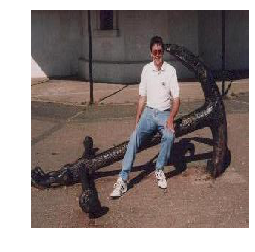

Beaver with id 1052 was in our set 1 times with score 1


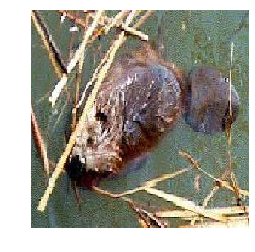

Buddha with id 1441 was in our set 1 times with score 2


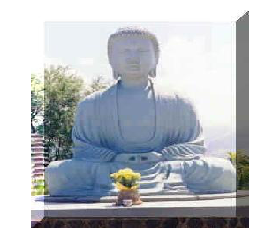

Crayfish with id 2279 was in our set 1 times with score 2 and 1 times with a score of 3


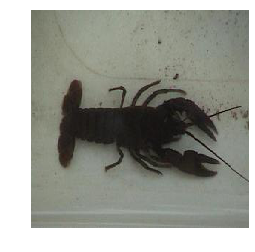

Faces_easy with id 3889 was in our set 3 times with score 3, 3 times with a score of 4, 7 times with a score of 5


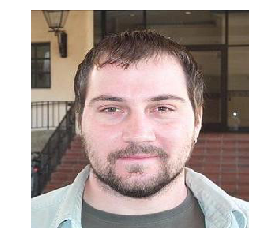

Leopards with id 5154 was in our set 9 times with score 5


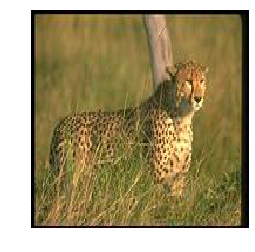

In [21]:
with open(os.path.join("data", "caltech101_VGG16_fc2.p"), "rb") as f:
  X_fc, y, X_paths, classes = pickle.load(f)
  X_paths = [x.replace('\\', '/') for x in X_paths]
  neigh = NearestNeighbors(n_neighbors=6, p=2, metric='l2')
  neigh.fit(X_fc)
    
# you can use this simple function to visualise an image, given a filepath
def show_img(filepath):
  img = image.load_img(filepath, target_size=(224,224))
  plt.imshow(img)
  plt.axis("off")
  plt.show()

#Anchor 0:2
#Example with a score of 0, 880
print("Anchor with id 880 was in our set 2 times with score 0")
show_img(X_paths[880])

#Beaver 1:1
#Example with a score of 1, 1052
print("Beaver with id 1052 was in our set 1 times with score 1")
show_img(X_paths[1052])

#Buddha 2:1
#Example with a score of 2, 1441
print("Buddha with id 1441 was in our set 1 times with score 2")
show_img(X_paths[1441])

#Crayfish 2:1, 3:1
#Example with a score of 3, 2279
print("Crayfish with id 2279 was in our set 1 times with score 2 and 1 times with a score of 3")
show_img(X_paths[2279])

#Faces_easy 3:3, 4:3, 5:7
#Example with a score of 4, 3889
print("Faces_easy with id 3889 was in our set 3 times with score 3, 3 times with a score of 4, 7 times with a score of 5")
show_img(X_paths[3889])

#Leopards 5:9
#Example with a score of 5, 5154
print("Leopards with id 5154 was in our set 9 times with score 5")
show_img(X_paths[5154])

***

**b)** Looking at the results, what can you say about the "types" of images that obtain good retrieval scores compared to those obtaining poor retrieval scores? Give an explanation and possible solution(s).

(*HINT: How did we obtain data representations for similarity measures?*)

**Answer:**

Using the data generated in task 1.1 we choose six examples, one for each score in the range $[0, 5]$:

* For the images with score 0, we immediately see that there is a person in front of the object. This is highly likely to cause the poor result.
* For the image with score 1, we also see that there is some wood in front of the beaver as well as much wood arround the beaver. This is probaly the cause for the bad score.
* For the image with score 2, we have the Buddha. This Buddha does not have much contrast with its background. Furthermore, it has a small object in front of him. Both can cause the below average performance of this image.
* For the image with score 3, we have the Crayfish. In this case there is nothing in front of the object and the object itself has some contrast from its background. The object itself however barely has any contrast making it less representive for its class.
* For the image with score 4, we have a picture of a face. This image fairly clear and therefore provides a fairly good result. When compared with other pictures of the class faces_easy we might expect it to perform even better. The catch here however is that the picture gets confused with the class faces which is really similair to faces_easy.
* For the picture with score 5, we have the leopard which in our case alwas gets a score of five. This is probally caused by the clear contour of the leopard (despite the bottem being covered in grass) and the distinct patern of dots on its fur.

***

### Task 1.3: Subjective evaluation
We will now use the "fc2"-features to do image retrieval for query images from the "BACKGROUND_Google" set from the Caltech101 dataset. These images are not associated to a particular class, so we will evaluate them subjectively instead.

**a)** Find two query images from the "BACKGROUND_Google" class, such that for the first query image relevant/similar images are retrieved (according to your own definition of relevancy/similarity), and for the second image mainly irrelevant/dissimilar images are retrieved. For each of them, visualise its 5 nearest neighbors in the Caltech101 dataset (*so do NOT retrieve images from the "BACKGROUND_Google" class!*), according to the "fc2-features" and L2-distance.

Google image: 


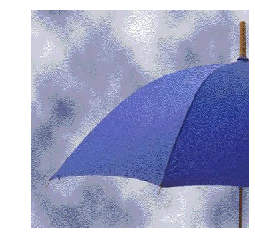

Neighbours: 


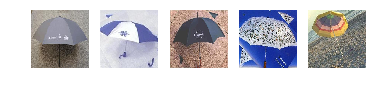

Google image: 


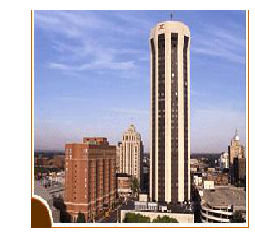

Neighbours: 


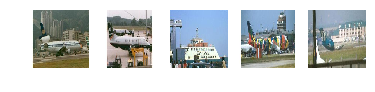

In [28]:
# From the above generated list of images we pick one image for which we think 
# the neighbours are relevant and one for which we think the neighbours are not.
with open(os.path.join("data","caltech101_VGG16_fc2_bg.p"), "rb") as f:
  bg_fc2, bg_paths = pickle.load(f)
  bg_paths = [x.replace('\\', '/') for x in bg_paths]

X = bg_fc2[[333, 44]]
_, ind = neigh.kneighbors(X)

# For the google image 333, we get an umberella with relevant neighbours.
print("Google image: ")
show_img(bg_paths[333])

print("Neighbours: ")
plt.figure()
for i, neighbourImg in enumerate(ind[0, 0:5]):
  plt.subplot(150+i+1)
  plt.axis('off')
  img = image.load_img(X_paths[int(neighbourImg)], target_size=(224,224))
  plt.imshow(img)
plt.show()
        
# For the google image 44 we get a tower with irrelevant neighbours.
print("Google image: ")
show_img(bg_paths[44])

print("Neighbours: ")
plt.figure()
plt.axis('off')
for i, neighbourImg in enumerate(ind[1, 0:5]):
  plt.subplot(150+i+1)
  plt.axis('off')
  img = image.load_img(X_paths[int(neighbourImg)], target_size=(224,224))
  plt.imshow(img)
plt.show()

***

**b)** Motivate your idea of "relevance": why do you consider the results for the first image relevant/similar, and those for the second image irrelevant/dissimilar?

**Answer:**

For the picture of half the blue umberella on a blue cloudy background we get five relevant images of which four contain an umberella and one a beach umbrella. Since they are all the same object the results are relevant. All the umberellas have the same shape and the beach umberella has a similair shape.  Further the background are mostly regular for all the results. The only exception again is the beach umberalle where the background is the beach and the sea.

For the picture of the white skyscraper surrounded by building with a blue sky in the background we get no relevant results. Al the neighbours of this image except one are airplanes. This is likely caused by the similar white shape. Most of the airplanes further have the same background as the skyscraper except from a lower angle. The third closest neighbour of the skyscraper is a boat with a similar long white shape with a darker line at the bottom and a blue sky in the background.


***

**c)** Explain why you think this retrieval method (nearest neighbor for neural codes from VGG16) performs better on the first image than on the second.

**Answer:**

The first image has one clear object, making it easy to only identify relevant features. Further the unberella has its own class in the origional dataset, the features of the google image umberella thus maps verry wel to the features of the umberellas on which our model was trained. Thus the representation of the new umberella will be closse to the umberellas from our dataset in our output space. For the skyscraper there are more features which our neural network can find, including the sky and the houses arround it. Also there is no dedicated class for skyscrapers in our training set, this means that the closest images in our feature space will have a different object in the foreground and that our model has not learned the exact features of a skyscraper. Giving this information it makes sense that the pictures of the airplanes were taken since these match some of the characteristics of the skyscraper and the surroundings were similair.

***

### Task 1.4: Dimensionality reduction

**a)** So far we've been using 4096-dimensional neural codes. This space is however still quite high-dimensional. Apply a dimensionality reduction method and evaluate the effect on the retrieval performance.

* Use PCA to obtain lower-dimensional representations of the Caltech101 data "fc2"-features (try the same compression rates as in Table 2 of the "Neural Codes for Image Retrieval" paper).
* Evaluate the same retrieval task as explained at the start of this question for each of the compression rates/dimensionalities. Report the retrieval scores.

*HINT: See http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html on how to transform a dataset with PCA.*

In [0]:
# import PCA from scikit-learn
from sklearn.decomposition import PCA

In [31]:
# load the data
with open(os.path.join("data", "caltech101_VGG16_fc2.p"), "rb") as f:
  X_fc, y, X_paths, classes = pickle.load(f)
  X_paths = [x.replace('\\', '/') for x in X_paths]
    
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

for n_components in [16, 32, 64, 128, 256, 512, 4096]:
    pca = PCA(n_components=n_components)
    pca.fit(X_fc)
    X_pca = pca.transform(X_fc)
    
    neigh = NearestNeighbors(n_neighbors=6, p=2, metric='l2')
    neigh.fit(X_pca)
    X = X_pca[indices]
    dist, ind = neigh.kneighbors(X)
    dist, ind = dist[:, 1:], ind[:, 1:]
    
    scores = [sum(classes[y[idx]] == classes[y[i]] for idx in ind[k]) for k, i in enumerate(indices)]
    avg_score = np.mean(scores)
    print('PCA(n_components={}) score: {}'.format(n_components, avg_score))

PCA(n_components=16) score: 3.6
PCA(n_components=32) score: 3.98
PCA(n_components=64) score: 4.23
PCA(n_components=128) score: 4.27
PCA(n_components=256) score: 4.25
PCA(n_components=512) score: 4.195
PCA(n_components=4096) score: 4.035


***

**b)** Discuss your results: how much can you further reduce the dimensionality of the data representations, without affecting the retrieval performance (much)? Compare these results to those from the paper, are your conclusions similar or not?

**Answer:**

When comparing our results to the results from the paper, we see a similar patern in scores. For 128, 256, 512 we get scores which are close to each other. For 64 dimensions, the score gets slightly lower. For 16 dimensions, the score is significantly lower. The exact same thing happens in the paper.

It is noteworthy that our predictions using PCA outperforms the predictions without PCA. Using 4096 dimensions results in a score of 3.765 (from 1.1) without PCA and results in a score of 4.035 with PCA (note that the random selections of the 200 images might have differed). This is probably because of the simplification in the coordinate system done by PCA.

It is further noteworthy that our scores are lower in the settings where we applied PCA with 4096 dimensions when compared to scores for PCA with lower dimensions. This is probally caused by the fact that more irrelevannt dimensions make the distance differences in the more relevevant dimensions less important. Thus reducing the quality of the predictions.


***

## Question 2: Fashion-MNIST (12.5pt)
For this question we will work with the "Fashion-MNIST" dataset. This dataset is modelled to have the same specifics as MNIST; it consists of a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 28x28 greyscale image, associated with a label from one of 10 classes. The images represent various clothing items (as opposed to handwritten digits for MNIST), each class represents a different type of clothing item. The following classes exist:
* 0:	T-shirt/top
* 1:	Trouser
* 2:	Pullover
* 3:	Dress
* 4:	Coat
* 5:	Sandal
* 6:	Shirt
* 7:	Sneaker
* 8:	Bag
* 9:	Ankle boot

In this question we will investigate various ways to model visual similarity for this dataset, in order to perform image retrieval. For more info about the dataset, see https://github.com/zalandoresearch/fashion-mnist.

The dataset can directly be obtained through Keras:

4423680/4422102 [==============================] - 3s 1us/step
X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


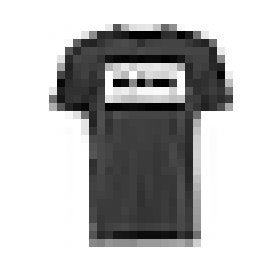

Class: T-shirt/top (0)


In [0]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras import backend as K

# load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# properties of the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# show an example
example_id = 1  # pick any integer from 0 to 59999 to visualize a training example
example = x_train[example_id].reshape(img_rows, img_cols)
label = y_train[example_id]
label_digit = y_train_digits[example_id]
label_class = classes[label_digit]
plt.matshow(example)
plt.axis("off")
plt.show()
print("Class: {} ({})".format(label_class, label_digit))

Consider the following situation: We have a fully labelled dataset (the ***labelled set***) of the images from the first 5 classes (t-shirts/tops, trousers, pullovers, dresses, coats). We are then supplied with an unlabelled dataset (the ***retrieval set***) containing the remaining Fashion-MNIST images (sandals, shirts, sneakers, bags, ankle boots) on which we want to be able to perform image retrieval. So we cannot use labels from the retrieval set, since we do not know them (note that in our case we *do* have the labels, but we will only use them for evaluation).

The following code splits the dataset up into two sets representing 5 classes each. Observe that the labelled and the retrieval set have exactly the same size.

In [0]:
# reshape x_train and x_test
# x_train = x_train.reshape(-1, 784)
# x_test = x_test.reshape(-1, 784)

# obtain indices of labelled and retrieval sets
indices_train_l = np.argwhere(y_train_digits < 5).flatten()  # indices labelled training set
indices_train_r = np.argwhere(y_train_digits >= 5).flatten()  # indices retrieval training set
indices_test_l = np.argwhere(y_test_digits < 5).flatten()  # indices labelled test set
indices_test_r = np.argwhere(y_test_digits >= 5).flatten()  # indices retrieval test set

# split up train and test set (images and labels)
x_train_l = x_train[indices_train_l]
x_train_r = x_train[indices_train_r]
y_train_l = y_train[indices_train_l]
y_train_r = y_train[indices_train_r]
y_train_digits_l = y_train_digits[indices_train_l]
y_train_digits_r = y_train_digits[indices_train_r]
x_test_l = x_test[indices_test_l]
x_test_r = x_test[indices_test_r]
y_test_l = y_test[indices_test_l]
y_test_r = y_test[indices_test_r]
y_test_digits_l = y_test_digits[indices_test_l]
y_test_digits_r = y_test_digits[indices_test_r]

# labels are now one-hot encoded 10-dimensional vectors, but only the first or last five dimensions are used
# omit unused dimensions to obtain 5-dimensional one-hot encodings
y_train_l = y_train_l[:, :5]
y_train_r = y_train_r[:, 5:]
y_test_l = y_test_l[:, :5]
y_test_r = y_test_r[:, 5:]
# (note that the dimensions of y_train_l/y_test_l do not correspond to those of y_train_r/y_test_r now)

# print the shapes
print(x_train_l.shape)
print(x_train_r.shape)
print(y_train_l.shape)
print(y_train_r.shape)
print(y_train_digits_l.shape)
print(y_train_digits_r.shape)
print(x_test_l.shape)
print(x_test_r.shape)
print(y_test_l.shape)
print(y_test_r.shape)
print(y_test_digits_l.shape)
print(y_test_digits_r.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000, 5)
(30000, 5)
(30000,)
(30000,)
(5000, 28, 28, 1)
(5000, 28, 28, 1)
(5000, 5)
(5000, 5)
(5000,)
(5000,)


***

### Task 2.1: Fashion neural retrieval
**a)** Design an MLP (multilayer perceptron) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use `x_train_l` for training). You may include Dropout and BatchNormalization if needed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train it to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 90%) on the labelled test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [0]:
# import sequential model and layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import Callback

class PlotAcc(Callback):
  """For plotting train and test accuracies after each epoch."""

  def on_train_begin(self, logs={}):
    self.accs = []
    self.val_accs = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    self.accs.append(logs.get('acc'))
    self.val_accs.append(logs.get('val_acc'))
    x = range(len(self.accs))

    clear_output(wait=True)
    plt.plot(x, self.accs, label="acc")
    plt.plot(x, self.val_accs, label="val_acc")
    plt.legend()
    plt.show()

class PlotLoss(Callback):
  """For plotting train and test losses after each epoch."""

  def on_train_begin(self, logs={}):
    self.losses = []
    self.val_losses = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    x = range(len(self.losses))

    clear_output(wait=True)
    plt.plot(x, self.losses, label="loss")
    plt.plot(x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show()

class EarlyStoppingByValue(Callback):
  """
  For stopping once minimum or maximum target score/accuracy/loss is achieved.

  Attributes:

  monitor: string, optional (default='val_loss')
  quality to monitor

  value: float, optional (default=0.00001)
  quality value below / above which the model should stop training.

  mode: one of {'min', 'max'}, optional (default='max')
  If mode='min', training will stop when monitored quality is greater than 
  value (treated as minimum value). If mode='max', training will stop when 
  monitored quality is less than value (treated as maximum value).

  verbose: 0 or 1, optional (default=0)
  verbosity mode.
  """

  def __init__(self, monitor='val_loss', value=0.00001, mode='max', verbose=0):
    super(Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.mode = mode
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    current = logs.get(self.monitor)
    if current is None:
      warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if self.mode == 'min':
      if current > self.value:
        if self.verbose > 0:
          print("Epoch %05d: early stopping THR" % epoch)
        self.model.stop_training = True
    elif self.mode == 'max':
      if current < self.value:
        if self.verbose > 0:
          print("Epoch %05d: early stopping THR" % epoch)
        self.model.stop_training = True
    else:
      warnings.warn("Early stopping mode must be min / max!", RuntimeWarning)

In [0]:
mlp = Sequential()

# === SOLUTION: ===
mlp.add(Dense(256, input_shape=input_shape, activation="relu"))
mlp.add(Flatten())
mlp.add(BatchNormalization())
mlp.add(Dropout(0.4))
mlp.add(Dense(384, activation="relu"))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.4))
mlp.add(Dense(128, activation="relu"))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.4))
mlp.add(Dense(128, name="neural_codes", activation="relu")) # penultimate hidden layer
mlp.add(Dense(5, name='output', activation="softmax"))
mlp.summary()
mlp.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 28, 28, 256)       512       
_________________________________________________________________
flatten_6 (Flatten)          (None, 200704)            0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 200704)            802816    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200704)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 384)               77070720  
_________________________________________________________________
batch_normalization_9 (Batch (None, 384)               1536      
_________________________________________________________________
dropout_13 (Dropout)         (None, 384)               0         
__________

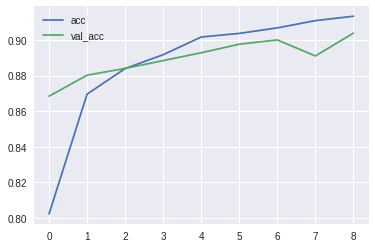

Test score: 0.2667367966532707
Test accuracy: 0.9038


In [0]:
# train and evaluate
batch_size = 500
nr_epochs = 30
plot_acc2 = PlotAcc()
early_stop = EarlyStoppingByValue(monitor='val_acc', value=0.9, mode='min')
history = mlp.fit(x=x_train_l, y=y_train_l,
                  batch_size=batch_size, epochs=nr_epochs,
                  verbose=1, callbacks=[plot_acc2, early_stop], 
                  validation_data=(x_test_l, y_test_l))
score = mlp.evaluate(x_test_l, y_test_l, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
# create directory if doesn't exist yet
try:
    os.mkdir("assignment2_models")
except(FileExistsError):
    pass

# save the model
mlp.save(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

We tested multiple architectures to design the MLP. The following lists the architectures tested in order of progression:
  * **First type**: 1 Input layer, 1 Flatten layer, 1 Hidden layer (neural codes) and Output layer. The model takes an input image and flattens it out because we need to convert it into a 5-class prediction output. There is a hidden layer which learns the image descriptors (neural codes) and output layer of 5 neurons with softmax activation to get probabilities of each class. Though simple, this model did not achieve 90% test accuracy. 
  
  * **Second type**: 1 Input layer, 1 Flatten layer, N Hidden layer(s), 1 Hidden layer (neural codes) and Output layer where $N \in [1, 3]$. This model had multiple issues. It was too simple and did not achieve 90% test accuracy, it was severely overfitting especially with increasing $N$ and lastly with increasing $N$, there was an exponentially increasing number of parameters to train. Therefore, it was not converging fast enough within 10-15 epochs.
  
  * **Third type**: 1 Input layer, 1 Flatten layer, N Hidden layer(s) + Dropouts (in between), 1 Hidden layer (neural codes) and Output layer where $N \in [1,2]$. Dropouts was added to control overfitting. A dropout rate of 0.4 was suitable for us. Using only dense layers prevents us from being able to reduce the size of the input, therefore $N=3$ was discarded to avoid training too many parameters. We achieved best results with $N=2$ but the model took >= 25-30 epochs to achieve a test accuracy > 90%.
  
  * **Fourth type**: 1 Input layer, 1 Flatten layer, 2 Hidden layers + BatchNormalization (in between), 1 Hidden layer (neural codes) and Output layer. We tried replacing dropouts with batch normalization in a plug-and-play and fashion to test, with the assumption that batch normalization also acts as a form of regularization. The network achieved higher validation accuracy faster but the regularization effect was insufficient to guard against overfitting.
  
  * **Fifth type**: 1 Input layer, 1 Flatten layer, 2 Hidden layers + (Dropout + BatchNormalization (in between)), 1 Hidden layer (neural codes) and Output layer. This architecture gave us the best results in terms of achieving 90% accuracy as well as training time < 10 epochs. We tested applying Batch normalization before and after dropouts but settled with applying it before. This is because dropouts randomly change the distribution of the activations of the previous layer which can cause internal covariate shift that cannot be properly adjusted by normalization.

Note:
* We only tested with ReLu activation for all hidden layers because this worked good enough for us.
* For training, we implemented a Keras callback function for early stopping once target accuracy was achieved. 
* We also implemented a callback function to plot the train and test accuracy after each epoch so it is easy to visualize how many epochs it took and to show that 90% test accuracy is achieved.

***

### Task 2.2: Fashion neural retrieval #2
**a)** Design a CNN (convolutional neural network) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use x_train_l for training), consisting of a number of Convolutions with Max-Pooling, followed by one or more Dense layers. You may use Dropout and BatchNormalization to improve generalization and training speed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train the CNN to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 94%) on the test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [0]:
# import additional layers
from keras.layers import Conv2D, MaxPooling2D

In [0]:
cnn = Sequential()

# === SOLUTION: ===
cnn.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation="relu"))
# cnn.add(MaxPooling2D((2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(BatchNormalization())
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.4))
cnn.add(Dense(128, activation="relu"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.4))
cnn.add(Dense(128, name="neural_codes", activation="relu")) # penultimate hidden layer
cnn.add(Dense(5, name='output', activation="softmax"))
cnn.summary()
cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_19 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
flatten_9 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               1605760   
__________

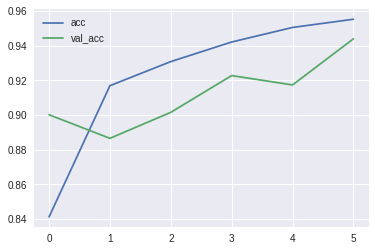

Test score: 0.17611857106685638
Test accuracy: 0.944


In [0]:
# train and evaluate
batch_size = 500
nr_epochs = 30
plot_acc2 = PlotAcc()
early_stop = EarlyStoppingByValue(monitor='val_acc', value=0.94, mode='min')
history = cnn.fit(x=x_train_l, y=y_train_l,
                  batch_size=batch_size, epochs=nr_epochs,
                  verbose=1, callbacks=[plot_acc2, early_stop], 
                  validation_data=(x_test_l, y_test_l))
score = cnn.evaluate(x_test_l, y_test_l, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
# save the model
cnn.save(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

We build the CNN with two Convolutional layers, followed by MaxPooling + BatchNormalization, followed by some Dense layers (with Dropout + BatchNormalization, similar to MLP).

* Initialize a sequential model.
* Add a convolutional layer with 32 filters, 3x3 kernel, ReLu activation and 'same' padding. The 'same' padding allows us to maintain the original image dimensions. This is followed by BatchNormalization to speed up training.
* Add another convolutional layer with 64 filters, 3x3 kernel, ReLu activation and 'same' padding to learn higher level features from the previous layer. Followed by MaxPooling to reduce the number of parameters to train (compressed representation) and followed again by BatchNormalization. We tested with MaxPooling after the first convolutional layer also but this reduces the dimensions too much and takes the model > 15 epochs to achieve 94% test accuracy versus the 6 epochs it takes now. This is probably because the 7x7 image output after applying two 2x2 MaxPooling layers is too down-scaled to provide a good representation.
* We then apply Dense layers similar to MLP model with dropouts + normalization in between. The dense layer expects flat input vector, so we first apply the Flatten layer.
* Lastly, we have one hidden layer for learning neural codes and one output layer with softmax activation.

***

### Task 2.3: Fashion neural retrieval #3
**a)** Design a (convolutional) Denoising Autoencoder (DAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the DAE to reconstruct noisy images to the original input images. Make sure that it achieves a binary cross-entropy loss of at most 0.29 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [0]:
# import additional layer
from keras.layers import UpSampling2D, Reshape

In [0]:
# obtain noisy version of data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


# define autoencoder
dae = Sequential()

# === SOLUTION: ===
# encoder
dae.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation="relu"))
dae.add(BatchNormalization())
dae.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
dae.add(MaxPooling2D((2, 2)))
dae.add(BatchNormalization())
dae.add(Flatten())
# dae.add(Dense(128, activation='relu'))
# dae.add(BatchNormalization())
# dae.add(Dropout(0.4))
dae.add(Dense(128, activation="relu"))
dae.add(BatchNormalization())
dae.add(Dropout(0.4))
dae.add(Dense(128, name="neural_codes", activation="relu"))

# decoder
dae.add(Dense(25088))
dae.add(Reshape((14, 14, 128)))
dae.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
dae.add(UpSampling2D((2, 2)))
dae.add(BatchNormalization())
dae.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
dae.summary()
dae.compile(loss="binary_crossentropy", optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_19 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
flatten_5 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1605760   
__________

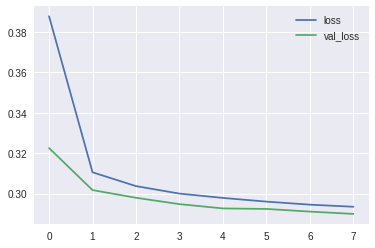

Test loss: 0.2899878089904785


In [0]:
# train and evaluate
batch_size = 500
nr_epochs = 30
plot_loss = PlotLoss()
early_stop = EarlyStoppingByValue(monitor='val_loss', value=0.29, mode='max')
history = dae.fit(x=x_train_noisy, y=x_train,
                  batch_size=batch_size, epochs=nr_epochs,
                  verbose=1, callbacks=[plot_loss, early_stop], 
                  validation_data=(x_test_noisy, x_test))
score = dae.evaluate(x_test_noisy, x_test, verbose=0)
print('Test loss:', score)

In [0]:
# save the model
dae.save(os.path.join("assignment2_models", "dae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

For the encoder, we use the same architecture as the CNN model up to the last hidden layer for the neural codes except with one hidden layer (+ batch normalization and dropout) removed. Removing the extra hidden layer sped up training and also achieved better loss. 

For the decoder, we use a Dense layer + Reshape to get back an image from the flattened representation before we apply convolution and upsampling. We then use batch normalization to speed up training. The last convolutional layer outputs a greyscale image with sigmoid activation for each pixel. We use ReLu activation and "same" padding for all convolutional layers except the last one.

***

Visualise a few test examples, their noisy versions, and their reconstructions.

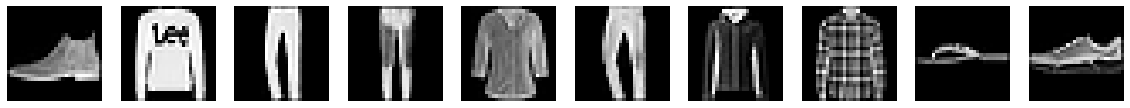

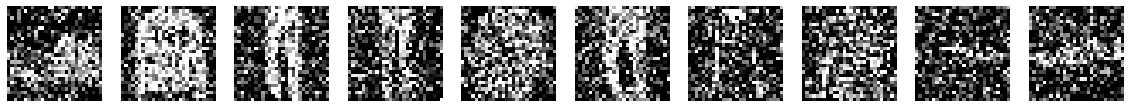

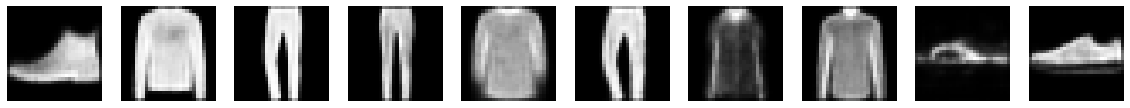

In [0]:
# NOTE: you don't need to change this code, just run it after having trained the DAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = dae.predict(x_test_noisy, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_noisy)
plot_examples(x_test_reconstr)

**c)** Do you consider the results acceptable? Do you think they can be useful for image retrieval? Explain why in one or two sentences.

**Answer:**

Yes, the results are acceptable. The output images predicted by the DAE shows that it has learned the representation of each class quite well without overfitting. For instance, if we look at the second image of the T-shirt class, we see that the output has a general outline of a T-shirt without the brand logo in between. We can use this representation for retrieval because it is generalized and captures all the visually essential features to discriminate between the classes clearly.

***

**d)** Why can we train on the full dataset `x_train` here, whereas in Tasks 2.1 and 2.2 we had to use `x_train_l` (the first 5 classes only) for training?

**Answer:**

The end goal of image retrieval is to find the most similar images to a query image without knowledge of the query image. For the MLP and CNN, knowing the class labels of the images in the retrieval set will allow the network to essentially "cheat" by just attempting to predict the class it belongs to. It is in our interest to predict something it has not seen before. For the DAE and SAE, we are trying to ouput images where the class is not relevant to the output. Having seen a class before does not give any advantage in generating its output.

***

### Task 2.4: Fashion neural retrieval #4
Autoencoders come in different shapes and sizes. One key defining property of autoencoders is the means the model uses to prevent the learning of the identity function. Typically, this is done with different regularization methods. In the previous task you used a model that uses noise as a regularizer. In this task you will develop a Sparse Autoencoder (SAE). A sparse autoencoder uses a sparsity regularization to obtain sparse representations of the input data. Sparsity can be achieved by using L1-regularization on the activations of the hidden "code" layer.

**a)** Design a (convolutional) Sparse Autoencoder (SAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). Add an activity regularizer to this layer, using `regularizers.l1(10e-5)` from Keras.
For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the SAE to reconstruct input images. Make sure that it achieves a loss value of at most 0.31 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [0]:
# import regularizers for sparse autoencoder
from keras import regularizers

In [0]:
# define autoencoder
sae = Sequential()

# === SOLUTION: ===
# encoder
sae.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation="relu"))
sae.add(BatchNormalization())
sae.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
sae.add(MaxPooling2D((2, 2)))
sae.add(BatchNormalization())
sae.add(Flatten())
sae.add(Dense(128, activation="relu"))
sae.add(BatchNormalization())
sae.add(Dropout(0.4))
sae.add(Dense(128, name="neural_codes", activation="relu", activity_regularizer=regularizers.l1(10e-5)))

# decoder
sae.add(Dense(25088))
sae.add(Reshape((14, 14, 128)))
sae.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
sae.add(UpSampling2D((2, 2)))
sae.add(BatchNormalization())
sae.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
sae.summary()
sae.compile(loss="binary_crossentropy", optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_23 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
flatten_6 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1605760   
__________

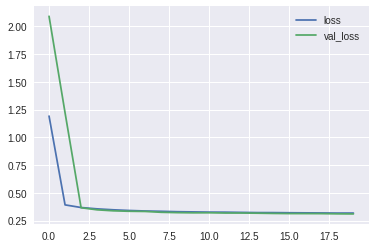

Test loss: 0.3036465986251831


In [0]:
# train and evaluate
batch_size = 500
nr_epochs = 30
plot_loss2 = PlotLoss()
early_stop = EarlyStoppingByValue(monitor='val_loss', value=0.31, mode='max')
history = sae.fit(x=x_train, y=x_train,
                  batch_size=batch_size, epochs=nr_epochs,
                  verbose=1, callbacks=[plot_loss2, early_stop], 
                  validation_data=(x_test, x_test))
score = sae.evaluate(x_test, x_test, verbose=0)
print('Test loss:', score)

In [0]:
# save the model
sae.save(os.path.join("assignment2_models", "sae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

The SAE architecture is identical to the DAE architecture with the only difference being the use of L1 kernel regularizer in the neural codes layer for learning sparse representation. We decided to use this architecture because it achieves test loss < 0.31.

***

Visualise a few test examples and their reconstructions.

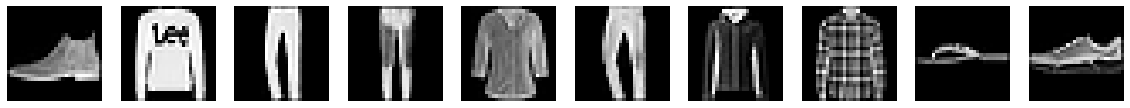

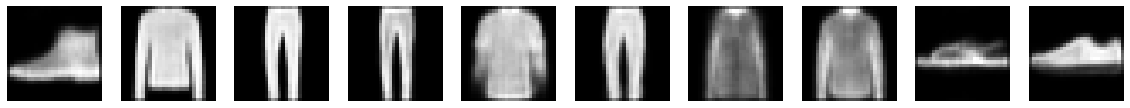

In [0]:
# NOTE: you don't need to change this code, just run it after having trained the SAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = sae.predict(x_test, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_reconstr)

**c)** Compare the visual results to those of the DAE in Task 2.3. Also compare the loss values of the test set for the DAE and SAE. How can you explain the difference?

**Answer:**

The visual reconstruction of the input by the DAE and the SAE are practically identical except perhaps in image 3, 6 and 9. Image 3 and 6 do not show the right leaning of the pant or trousers as clearly as reproduced by the DAE. Image 9 produces a small streak of light grey over the sandals which is not present in the original image or in the DAE results. But the overall features of the classes is captured well enough.

In training, we applied early stopping to ensure models are not trained further once target loss is achieved. With that in mind, the DAE achieves 0.289 test loss with target loss < 0.29 after just 8 epochs whereas the SAE achieves test loss of 0.303 with target loss of < 0.31 in 18 epochs. It takes a lot longer for SAE to reduce its loss lesser than a target loss which is higher than the target loss of DAE. Also from the plots of both, we can deduce that the DAE loss could be further reduced maybe but the SAE loss does not seem capable of decreasing further. 

The difference can be explained by the fact that finding a forced sparse representation is a lot harder than simply denoising. Denoising also forces the network to learn robust features that tend to generalize better.

In [0]:
!ls assignment2_models

cnn_fashionmnist_l.h5  mlp_fashionmnist_l.h5
dae_fashionmnist.h5    sae_fashionmnist.h5


In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload

def download_from_gdrive(file_name, file_id):
  """Download a file from google drive.
  
  Attributes:
    file_name: string
      Name to save the file with.
    
    file_id: string
      A file ID looks like: 1uBtlaggVyWshwcyP6kEI-y_W3P8D26sz
  """

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = open(file_name, "wb")
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  current_progress = -1

  while done is False:
    status, done = downloader.next_chunk()
    if status:
      if current_progress != status.progress():
        current_progress = status.progress()
        clear_output(wait=True)
        print("Download %d%%." % int(current_progress * 100))

In [0]:
# zip all models and save to google drive
!ls
!rm -f models.zip
!zip -r models.zip assignment2_models

file_metadata = {
  'name': 'models.zip',
  'mimeType': 'application/zip'
}
media = MediaFileUpload('models.zip', 
                        mimetype='application/zip',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1HXMYBqCHwxCvz0eJPrVLejhysOHvtIL5


In [0]:
# Download the models zip file.
file_id = '1s2o_jKWuQ4mptIVHGAdmvzyCWUgGaIoC'
download_from_gdrive('models.zip', file_id)

Download 100%.


In [0]:
!unzip 

***

### Task 2.5: Comparison
Obtain 128-dimensional neural code representations of the last five classes of the Fashion-MNIST dataset (the *retrieval set*: `x_train_r`) from the following models/layers:
1. The last dense hidden layer (before the output layer) of the MLP you trained in Task 2.1
2. The last dense hidden layer (before the output layer) of the CNN you trained in Task 2.2
3. The center layer/code of the DAE you trained in Task 2.3
4. The center layer/code of the SAE you trained in Task 2.4
5. A PCA-transformation

In [0]:
# additional imports
from keras.models import load_model
from keras.models import Model

In [0]:
# load the previously trained and saved models
mlp = load_model(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))
cnn = load_model(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))
dae = load_model(os.path.join("assignment2_models", "dae_fashionmnist.h5"))
sae = load_model(os.path.join("assignment2_models", "sae_fashionmnist.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
mlp_nc = Model(inputs=mlp.input, outputs=mlp.get_layer("neural_codes").output)
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes").output)
dae_nc = Model(inputs=dae.input, outputs=dae.get_layer("neural_codes").output)
sae_nc = Model(inputs=sae.input, outputs=sae.get_layer("neural_codes").output)

# obtain flat representations of the data
x_train_r_flat = x_train_r.reshape((x_train_r.shape[0], -1))
x_test_r_flat = x_test_r.reshape((x_test_r.shape[0], -1))

# train PCA on the retrieval set
pca = PCA(n_components=128)
pca.fit(x_train_r_flat)

# obtain 128-dimensional representations
nc_mlp_train = mlp_nc.predict(x_train_r)
nc_mlp_test = mlp_nc.predict(x_test_r)
nc_cnn_train = cnn_nc.predict(x_train_r)
nc_cnn_test = cnn_nc.predict(x_test_r)
nc_dae_train = dae_nc.predict(x_train_r)
nc_dae_test = dae_nc.predict(x_test_r)
nc_sae_train = sae_nc.predict(x_train_r)
nc_sae_test = sae_nc.predict(x_test_r)
nc_pca_train = pca.transform(x_train_r_flat)
nc_pca_test = pca.transform(x_test_r_flat)

# print the shapes to confirm all features are 128-dimensional
print(nc_mlp_train.shape)
print(nc_mlp_test.shape)
print(nc_cnn_train.shape)
print(nc_cnn_test.shape)
print(nc_dae_train.shape)
print(nc_dae_test.shape)
print(nc_sae_train.shape)
print(nc_sae_test.shape)
print(nc_pca_train.shape)
print(nc_pca_test.shape)

(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)


***

**a)** Evaluate the retrieval task as described in Question 1 on the last 5 classes (the retrieval set) of the Fashion-MNIST dataset, for the five data representations given above. Use query images from the test set and retrieve images from the training set only. Print the five resulting retrieval scores (between 0 and 5).

*HINT: you can use* `y_train_digits_r` *and* `y_test_digits_r` *to obtain digit encodings (as opposed to one-hot encodings) of the data labels.*

In [0]:
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 5000  # the retrieval test set has 5000 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

representations = [
    ('MLP', nc_mlp_train, nc_mlp_test),
    ('CNN', nc_cnn_train, nc_cnn_test),
    ('DAE', nc_dae_train, nc_dae_test),
    ('SAE', nc_sae_train, nc_sae_test),
    ('PCA', nc_pca_train, nc_pca_test),
]

for (name, nc_train, nc_test) in representations:
    # === SOLUTION: ===
    x_nc_test = nc_test[indices]
    
    neigh = NearestNeighbors(n_neighbors=6, p=2, metric='l2')
    neigh.fit(nc_train)
    dist, ind = neigh.kneighbors(x_nc_test)
    dist, ind = dist[:, 1:], ind[:, 1:]
    
    scores = [sum(y_train_digits_r[idx] == y_test_digits_r[i] for idx in ind[k]) for k, i in enumerate(indices)]
    avg_score = np.mean(scores)
    print('{} score: {}'.format(name, avg_score))

MLP score: 4.39
CNN score: 4.325
DAE score: 4.665
SAE score: 4.545
PCA score: 4.725


***

**b)** Compare the "baseline" PCA-transformed data with the other methods. Is PCA a suitable method to obtain representations for image retrieval in this situation? Why do you think so? Would you expect a similar conclusion for the Caltech101 dataset from Question 1?

**Answer:**

PCA method performs surprisingly best over all other approaches. Clearly it is very suitable to obtain representation for image retrieval.

***

Observe the difference between encodings from the DAE and SAE.

In [0]:
print("Mean activation for DAE encodings:", np.mean(nc_dae_train))
print("Mean activation for SAE encodings:", np.mean(nc_sae_train))

index = 2  # try a few indices here
print("DAE encoding example:")
print(nc_dae_train[index])
print("SAE encoding example:")
print(nc_sae_train[index])

Mean activation for DAE encodings: 0.69291484
Mean activation for SAE encodings: 0.0010278564
DAE encoding example:
[0.25931412 0.         2.5308523  0.         0.2647184  0.5854091
 0.         1.0279542  0.         0.         4.1908545  0.
 0.5028226  0.         0.         0.         0.         0.
 0.         0.         0.8386228  0.         0.85938257 0.
 0.         0.         1.034363   0.         1.1867679  1.3495384
 0.         0.         0.8521154  0.         0.         0.04234817
 0.2393952  1.9777051  0.         0.         0.         0.
 1.9835097  0.         0.         0.         0.         0.91976446
 0.         0.         3.4987664  0.6845333  0.         0.61480457
 0.         0.24469234 0.         0.01715669 0.         0.
 1.7366662  0.         0.         0.         0.         0.
 0.         0.55377316 0.         0.         0.         0.
 0.         0.2116454  0.37064266 0.         0.         0.
 0.         0.         0.         1.7109742  0.         4.1421914
 0.         0

**c)** Discuss the difference in encodings between the two autoencoders (denoising and sparse). Also discuss the difference in retrieval performance for these encodings. How would you explain this difference?

**Answer:**

The most obvious to note is that the neural codes produced by the SAE is very sparse. The DAE has better score than the SAE. This can be attributed to the forced sparse activation factor which reduces

***

**d)** What is the best performing method you found in part a)? Describe what advantage you believe this method has over the others.

**Answer:**

PCA is the best performing method we found. PCA calculates the principal components of the images to convert the dimensions, which can contain essential features to image retrieval.